**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

In [2]:
# insert code here
#%pip install ucimlrepo
from sklearn.model_selection import train_test_split 
import pandas as pd

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data = pd.read_csv(url, names=column_names, na_values='?')

heart_data.info()
heart_data.describe()
print(heart_data['target'].value_counts()) # occurrences of each label

X = heart_data.iloc[:,:13]
y = heart_data.iloc[:,13:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratify because of imbalanced dataset



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
0    164
1     55
2     36
3     35
4     13
Name: target, dtype: int64


# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

In [3]:
# insert code here
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

#1. missing values
#print(heart_data.isnull().sum())
numerical_features = heart_data.select_dtypes(include=['float64']).columns

imputer = SimpleImputer(strategy='mean')
X_train[numerical_features] = imputer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = imputer.transform(X_test[numerical_features])
"""
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y.iloc[X_train.index]
y_test = y.iloc[X_test.index]
"""
#2. & 3.

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

#check type of feature for different preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features),
                  ('cat', OneHotEncoder(), categorical_features) 
                  ]
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.fit_transform(X_test)

print(X_train_prep.shape)
print(X_test_prep.shape)

(242, 38)
(61, 38)


# Task 3: Initial XGBoost Model
1. Build an initial XGBoost model using default hyperparameters.
2. Train the model on the training set and evaluate its performance on the testing set.
3. Note down the accuracy and any other relevant metrics.

In [4]:
# insert code here

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Create an XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train_prep, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test_prep)

# Evaluate the accuracy of the model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f'Test accuracy {xgb_accuracy}')

Test accuracy 0.5573770491803278


# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [5]:
# insert code here

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#grid search with cross validation
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [10, 30, 70, 100],
    'max_depth': [3, 4, 5, 6, 10],
    #"max_leaves":[0, 2, 4, 5, 10],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
}


cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1)

#train models

res = grid_search.fit(X_train_prep, y_train)
print("Best Grid Hyperparameters:", res.best_params_)
print("Best Grid Accuracy: {:.2f}".format(res.best_score_))

#test best model

xgb_best = res.best_estimator_

y_pred_best = xgb_best.predict(X_test_prep)

accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Model Test Accuracy:", accuracy_best)


Best Grid Hyperparameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 30}
Best Grid Accuracy: 0.61
Best Model Test Accuracy: 0.5901639344262295


# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

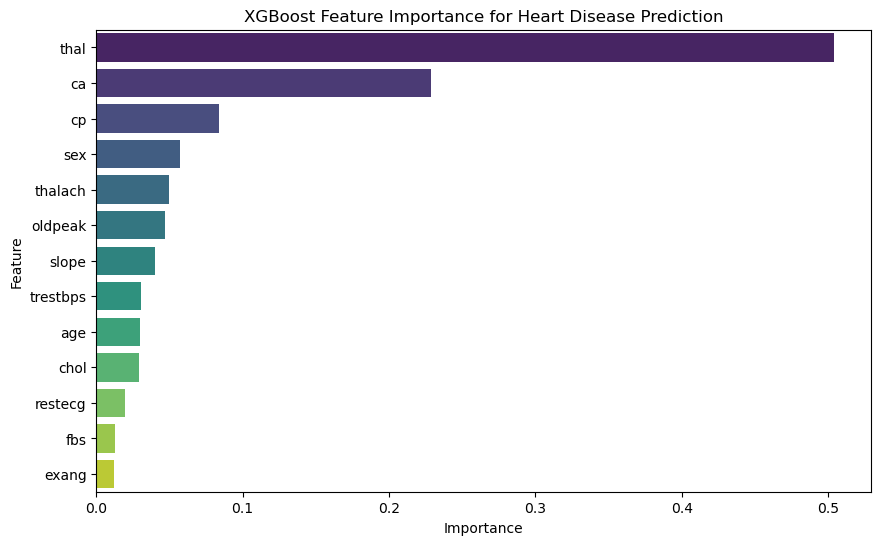

Top Features:
   Feature  Importance
12    thal    0.504295
11      ca    0.228940
2       cp    0.083819


In [6]:
# insert code here
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Explore and plot feature importance
feature_importance = xgb_best.feature_importances_
feature_names_encoded = preprocessor.get_feature_names_out() #get names of encoded features

original_feature_names = X.columns
original_feature_importance = []

for original_feature in original_feature_names:
    # Find all one-hot encoded features related to the original feature
    relevant_encoded_features = [feature for feature in feature_names_encoded if original_feature in feature]
    
    # Sum the importance scores of all related one-hot encoded features
    importance_sum = sum(feature_importance[preprocessor.get_feature_names_out().tolist().index(encoded_feature)] for encoded_feature in relevant_encoded_features)
    
    original_feature_importance.append(importance_sum)


feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': original_feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XGBoost Feature Importance for Heart Disease Prediction')
plt.show()

# 2. 3 most important features
top_features = feature_importance_df.head(3) 
print("Top Features:")
print(top_features)


# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

Initial Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        33
           1       0.17      0.18      0.17        11
           2       0.20      0.29      0.24         7
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.56        61
   macro avg       0.24      0.28      0.25        61
weighted avg       0.49      0.56      0.52        61


Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81        33
           1       0.12      0.09      0.11        11
           2       0.38      0.43      0.40         7
           3       0.60      0.43      0.50         7
           4       0.00      0.00      0.00         3

    accuracy                           0.59        61
   macro avg       0.37      0.37      0.36        61
weig

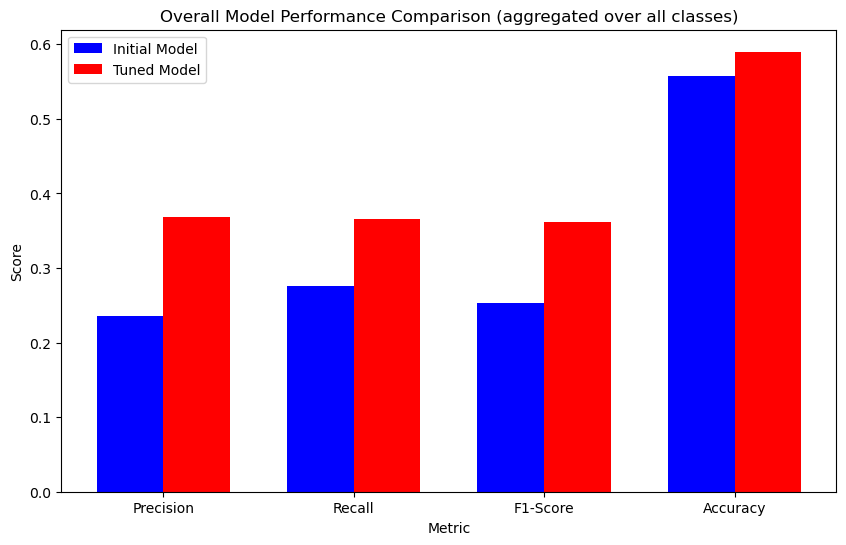

3. Discussion

Even though the overall performance of the classifier still doesn't look great, hyperparameter tuning has led to improvements in overall precision, recall, f1-score and accuracy.
When considering the context of the data, it is of biggest importance to predict the classes for higher heart disease risk correctly.
We didn't predict a single instance of class=4 correctly, which is bad, but we did significantly increase the performance on the labels 2 and 3.
The feature importance values give us info about how influential features are for the classification.
We might consider dropping some features that are not relevant to prevent overfitting, which should result in better performance on test data, and increase computational efficency.


In [8]:
# insert code here
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


# 1. Compare performance metrics of initial and improved model
print("Initial Model Classification Report:")
report_initial=classification_report(y_test, xgb_predictions, zero_division=0)
print(report_initial)

print("\nTuned Model Classification Report:")
report_tuned=classification_report(y_test, y_pred_best, zero_division=0)
print(report_tuned)

# 2. Calculate and plot accuracy, precision, recall, F1-score averaged over all 5 classes 
# (not weighted, because i want all classes to have the same relevance for the measures)
precision_initial, recall_initial, f1_initial, _ = precision_recall_fscore_support(y_test, xgb_predictions, average='macro', zero_division=0)
precision_tuned, recall_tuned, f1_tuned, _ = precision_recall_fscore_support(y_test, y_pred_best, average='macro', zero_division=0)

metric_names = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
metric_values_initial = [precision_initial, recall_initial, f1_initial, xgb_accuracy]
metric_values_tuned = [precision_tuned, recall_tuned, f1_tuned, accuracy_best]

width = 0.35 
ind = range(len(metric_names))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(ind, metric_values_initial, width, label='Initial Model', color='b')
bar2 = ax.bar([i + width for i in ind], metric_values_tuned, width, label='Tuned Model', color='r')

ax.set_title('Overall Model Performance Comparison (aggregated over all classes)')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_xticks([i + width/2 for i in ind])
ax.set_xticklabels(metric_names)
ax.legend()

plt.show()

#3
print("3. Discussion")
print("\nEven though the overall performance of the classifier still doesn't look great, hyperparameter tuning has led to improvements in overall precision, recall, f1-score and accuracy." )
print("When considering the context of the data, it is of biggest importance to predict the classes for higher heart disease risk correctly.")
print("We didn't predict a single instance of class=4 correctly, which is bad, but we did significantly increase the performance on the labels 2 and 3.")
print("The feature importance values give us info about how influential features are for the classification.")
print("We might consider dropping some features that are not relevant to prevent overfitting, which should result in better performance on test data, and increase computational efficency.")